## Model

In [3]:
## For Model
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from fredapi import Fred
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

## For Dashboard
import dash
import dash_core_components as dcc
import dash_html_components as html




[*********************100%***********************]  2 of 2 completed


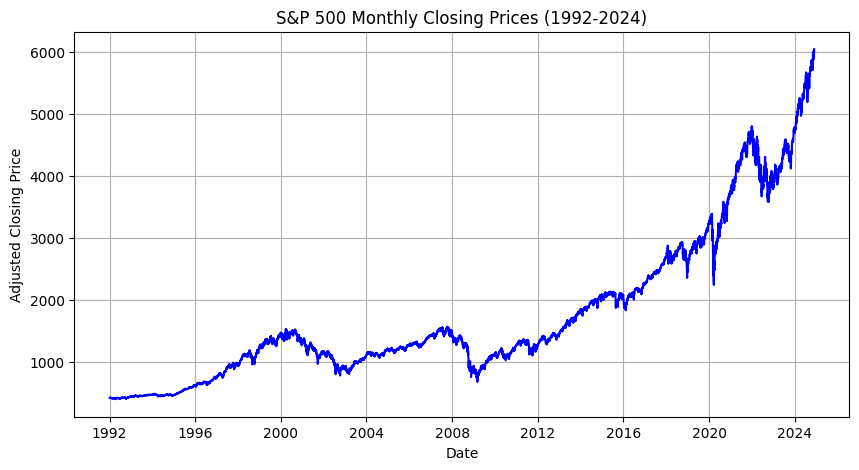

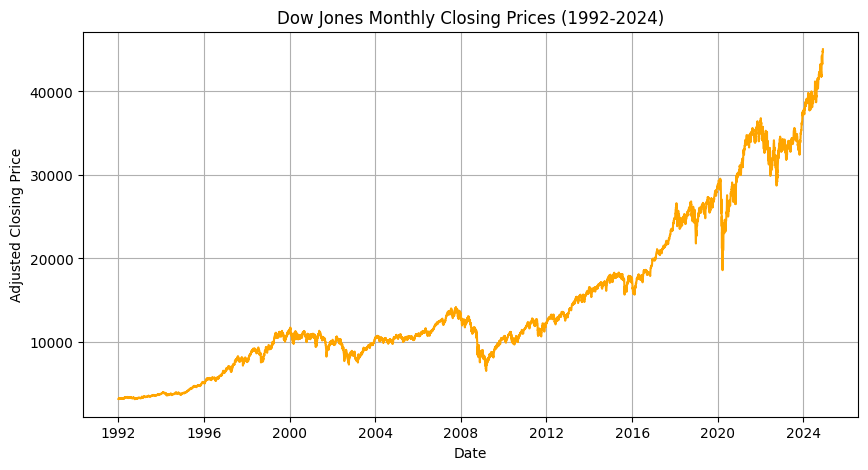

In [4]:
# S&P 500 and Dow Jones data from Yahoo Finance
# Stock Market Data

start_date = '1992-01-02'

tickers = ["^GSPC", "^DJI"]
stock_market_data = yf.download(
    tickers, start=start_date, end="2024-12-31", interval="1d"
)

sp500_data = stock_market_data["Adj Close"]["^GSPC"]

dowjones_data = stock_market_data["Adj Close"]["^DJI"]

dowjones_data = dowjones_data.dropna()


# Plot for S&P 500
plt.figure(figsize=(10, 5))
plt.plot(sp500_data.index, sp500_data, color="blue")
plt.title("S&P 500 Monthly Closing Prices (1992-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.grid()
plt.show()

# Plot for Dow Jones
plt.figure(figsize=(10, 5))
plt.plot(dowjones_data.index, dowjones_data, color="orange")
plt.title("Dow Jones Monthly Closing Prices (1992-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.grid()
plt.show()


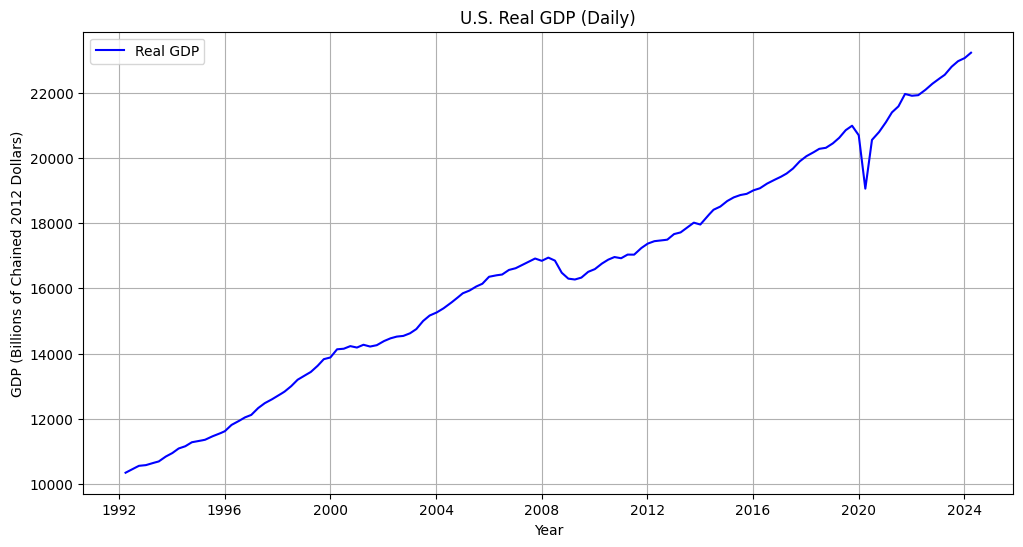

'\n1947-01-01  2182.681\n1947-04-01  2176.892\n'

In [5]:
# GDP data from FRED
gdp_data = pd.read_csv("gdp_data_1965_2024.csv")
gdp_data.rename(columns={
    "Unnamed: 0": "date"
}, inplace=True)
gdp_data['date'] = pd.to_datetime(gdp_data['date'])

gdp_data.set_index("date", inplace=True)

daily_index = pd.date_range(start=start_date, end=gdp_data.index.max(), freq='D')

gdp_data_daily = gdp_data.reindex(daily_index)

gdp_data_daily['Real GDP'] = gdp_data_daily['Real GDP'].interpolate(method='linear')

gdp_data_daily = gdp_data_daily.loc[start_date:]

# Plot for GDP
plt.figure(figsize=(12, 6))
plt.plot(
    gdp_data_daily.index,
    gdp_data_daily["Real GDP"],
    color="blue",
    label="Real GDP",
)
plt.title("U.S. Real GDP (Daily)")
plt.xlabel("Year")
plt.ylabel("GDP (Billions of Chained 2012 Dollars)")
plt.grid()
plt.legend()
plt.show()

"""
1947-01-01  2182.681
1947-04-01  2176.892
"""



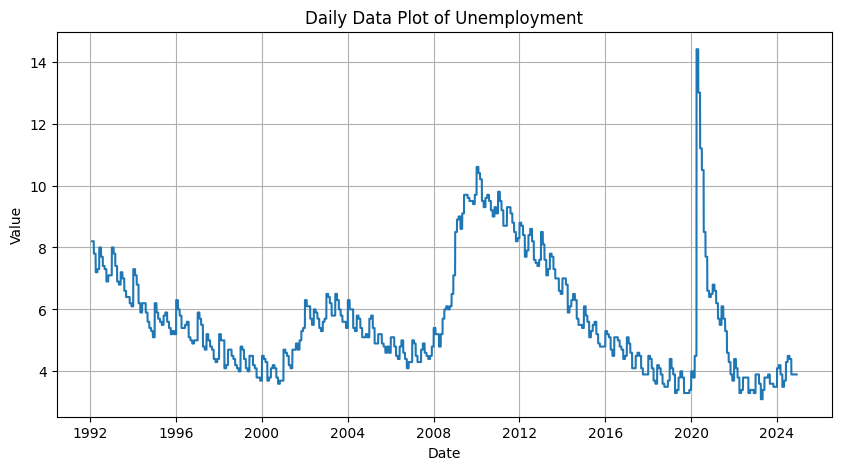

In [6]:
# Unemployment Data
unemployment_data = pd.read_csv("unemployment_data.csv")

unemployment_data_long = unemployment_data.melt(
    id_vars=["Year"], var_name="Month", value_name="Value"
)

unemployment_data_long["Month"] = pd.to_datetime(
    unemployment_data_long["Month"], format="%b"
).dt.month

unemployment_data_long["Date"] = pd.to_datetime(
    unemployment_data_long[["Year", "Month"]].assign(Day=1)
)

unemployment_data_long = unemployment_data_long.sort_values("Date")

unemployment_data_long.set_index("Date", inplace=True)

daily_index = pd.date_range(
    start=start_date, 
    end=unemployment_data_long.index.max(), 
    freq='D')

unemployment_data_daily = unemployment_data_long.reindex(daily_index)

unemployment_data_daily = unemployment_data_daily.fillna(method="ffill")

unemployment_data_daily.index.name = 'Date'

# Plot for unemployment rate
plt.figure(figsize=(10, 5))
plt.plot(unemployment_data_daily.index, unemployment_data_daily["Value"])
plt.title("Daily Data Plot of Unemployment")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid()
plt.show()

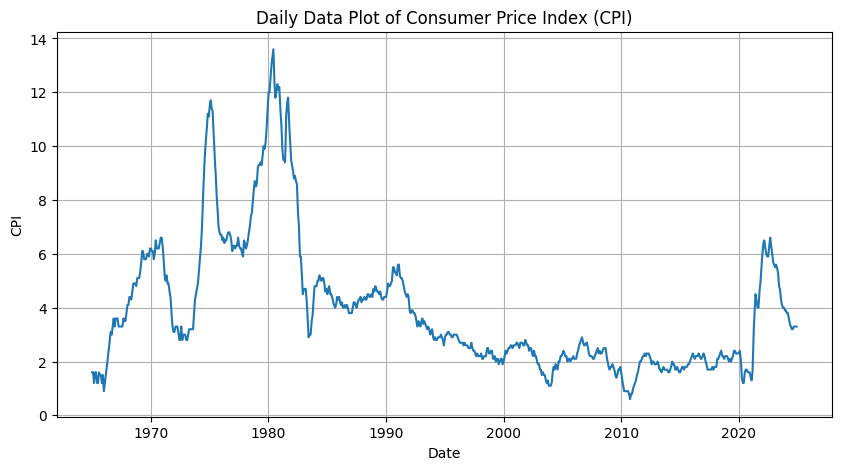

In [7]:
# CPI Data
cpi_data = pd.read_csv("cpi_data.csv")
cpi_data.drop(columns=["HALF1", "HALF2"], inplace=True)
cpi_data_long = cpi_data.melt(id_vars=["Year"], var_name="Month", value_name="CPI")
cpi_data_long["Month"] = pd.to_datetime(cpi_data_long["Month"], format="%b").dt.month
cpi_data_long["Date"] = pd.to_datetime(cpi_data_long[["Year", "Month"]].assign(Day=1))
cpi_data_long = cpi_data_long.sort_values("Date")

daily_index = pd.date_range(start=cpi_data_long['Date'].min(), 
                            end=cpi_data_long['Date'].max(), 
                            freq='D')

cpi_data_daily = cpi_data_long.set_index('Date').reindex(daily_index)

cpi_data_daily['CPI'] = cpi_data_daily['CPI'].interpolate(method='linear')
cpi_data_daily['Year'] = cpi_data_daily['Year'].fillna(method="ffill")
cpi_data_daily['Month'] = cpi_data_daily['Month'].fillna(method="ffill")

cpi_data_daily.index.name = 'Date'

# Plot for CPI
plt.figure(figsize=(10, 5))
plt.plot(cpi_data_daily.index, cpi_data_daily["CPI"])
plt.title("Daily Data Plot of Consumer Price Index (CPI)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.grid()
plt.show()

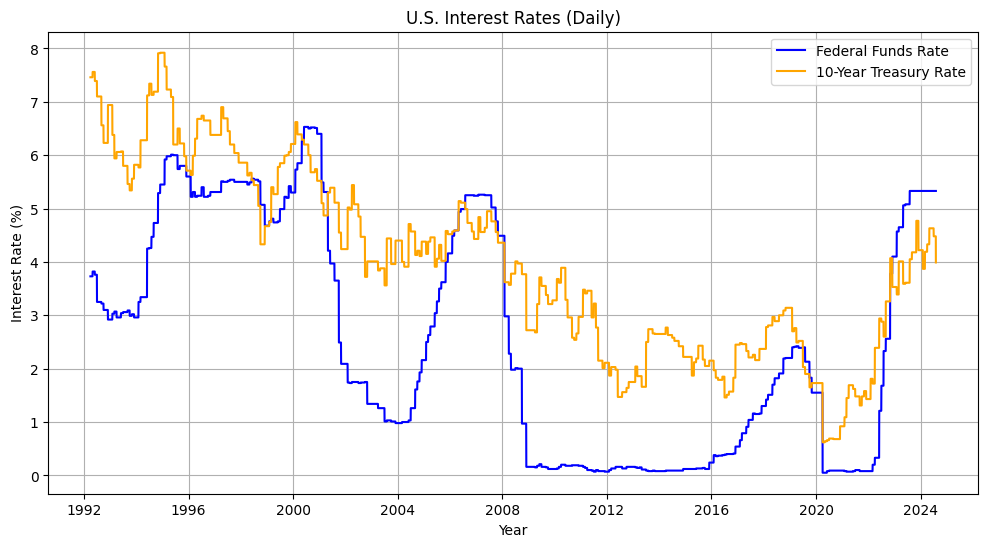

In [8]:
# Interest Rates Data
interest_rates_df = pd.read_csv(
    "interest_rates_1965_2024.csv", index_col=0, parse_dates=True
)

interest_rates_df = interest_rates_df.dropna()

daily_index = pd.date_range(start=start_date, 
                            end=interest_rates_df.index.max(), 
                            freq='D')

interest_rates_daily = interest_rates_df.reindex(daily_index)

interest_rates_daily = interest_rates_daily.fillna(method='ffill')

interest_rates_daily.index.name = 'Date'


# Plot for Interest Rates
plt.figure(figsize=(12, 6))
plt.plot(
    interest_rates_daily.index,
    interest_rates_daily["Federal Funds Rate"],
    label="Federal Funds Rate",
    color="blue",
)
plt.plot(
    interest_rates_daily.index,
    interest_rates_daily["10-Year Treasury Rate"],
    label="10-Year Treasury Rate",
    color="orange",
)
plt.title("U.S. Interest Rates (Daily)")
plt.xlabel("Year")
plt.ylabel("Interest Rate (%)")
plt.legend()
plt.grid()
plt.show()

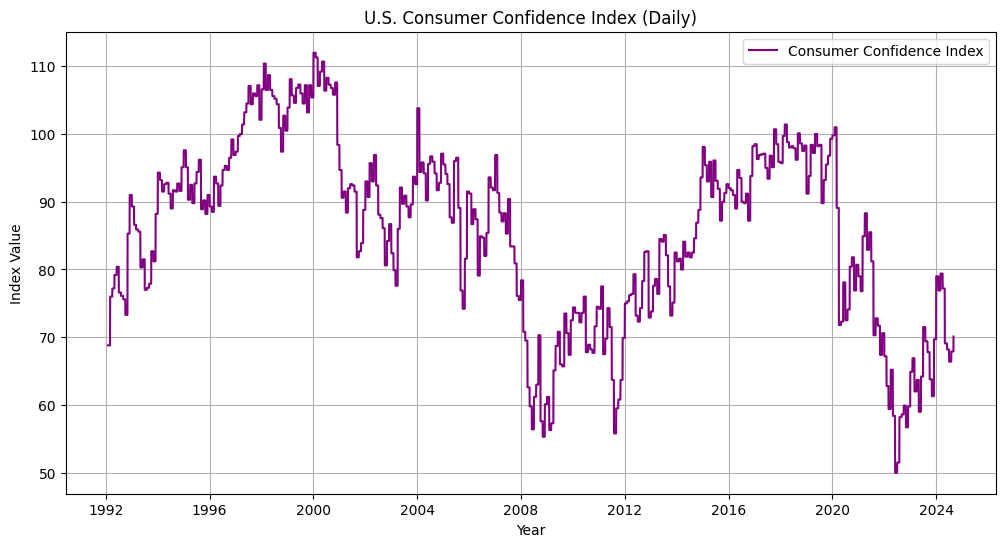

In [9]:
# Consumer Confidence Index Data
consumer_confidence_df = pd.read_csv(
    "consumer_confidence_index_1965_2024.csv", index_col=0, parse_dates=True
)
consumer_confidence_df = consumer_confidence_df[
    consumer_confidence_df.index >= "1965-01-01"
]

consumer_confidence_df = consumer_confidence_df.dropna(how="all")

daily_index = pd.date_range(start=start_date, 
                            end=consumer_confidence_df.index.max(), 
                            freq='D')

consumer_confidence_daily = consumer_confidence_df.reindex(daily_index)

consumer_confidence_daily = consumer_confidence_daily.fillna(method='ffill')

consumer_confidence_daily.index.name = 'Date'


# Plot for Consumer Confidence Index
plt.figure(figsize=(12, 6))
plt.plot(
    consumer_confidence_daily.index,
    consumer_confidence_daily["Consumer Confidence Index"],
    color="purple",
    label="Consumer Confidence Index",
)
plt.title("U.S. Consumer Confidence Index (Daily)")
plt.xlabel("Year")
plt.ylabel("Index Value")
plt.grid()
plt.legend()
plt.show()

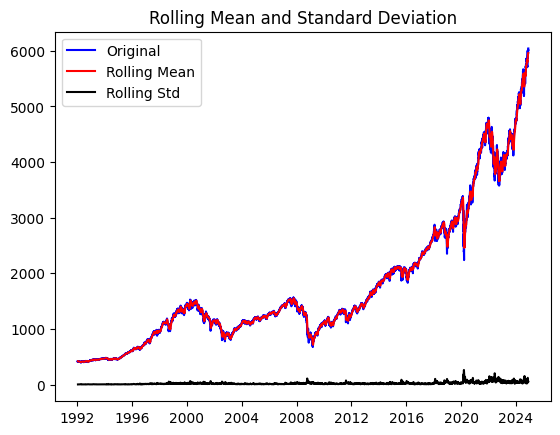

Results of dickey fuller test
Test Statistics                   3.221668
p-value                           1.000000
No. of lags used                 30.000000
Number of observations used    8259.000000
critical value (1%)              -3.431142
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64


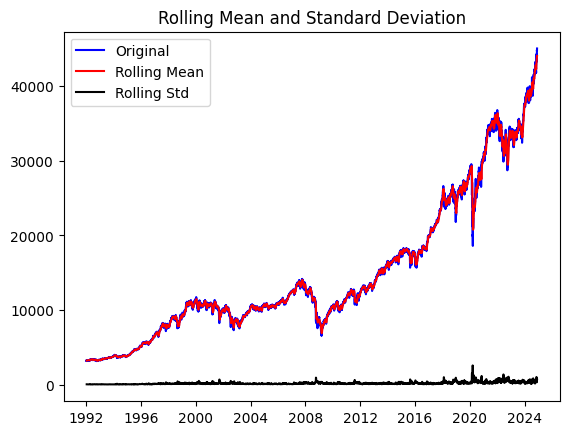

Results of dickey fuller test
Test Statistics                   2.273754
p-value                           0.998938
No. of lags used                 31.000000
Number of observations used    8258.000000
critical value (1%)              -3.431142
critical value (5%)              -2.861890
critical value (10%)             -2.566956
dtype: float64


In [10]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(sp500_data)
test_stationarity(dowjones_data)

<Figure size 1000x600 with 0 Axes>

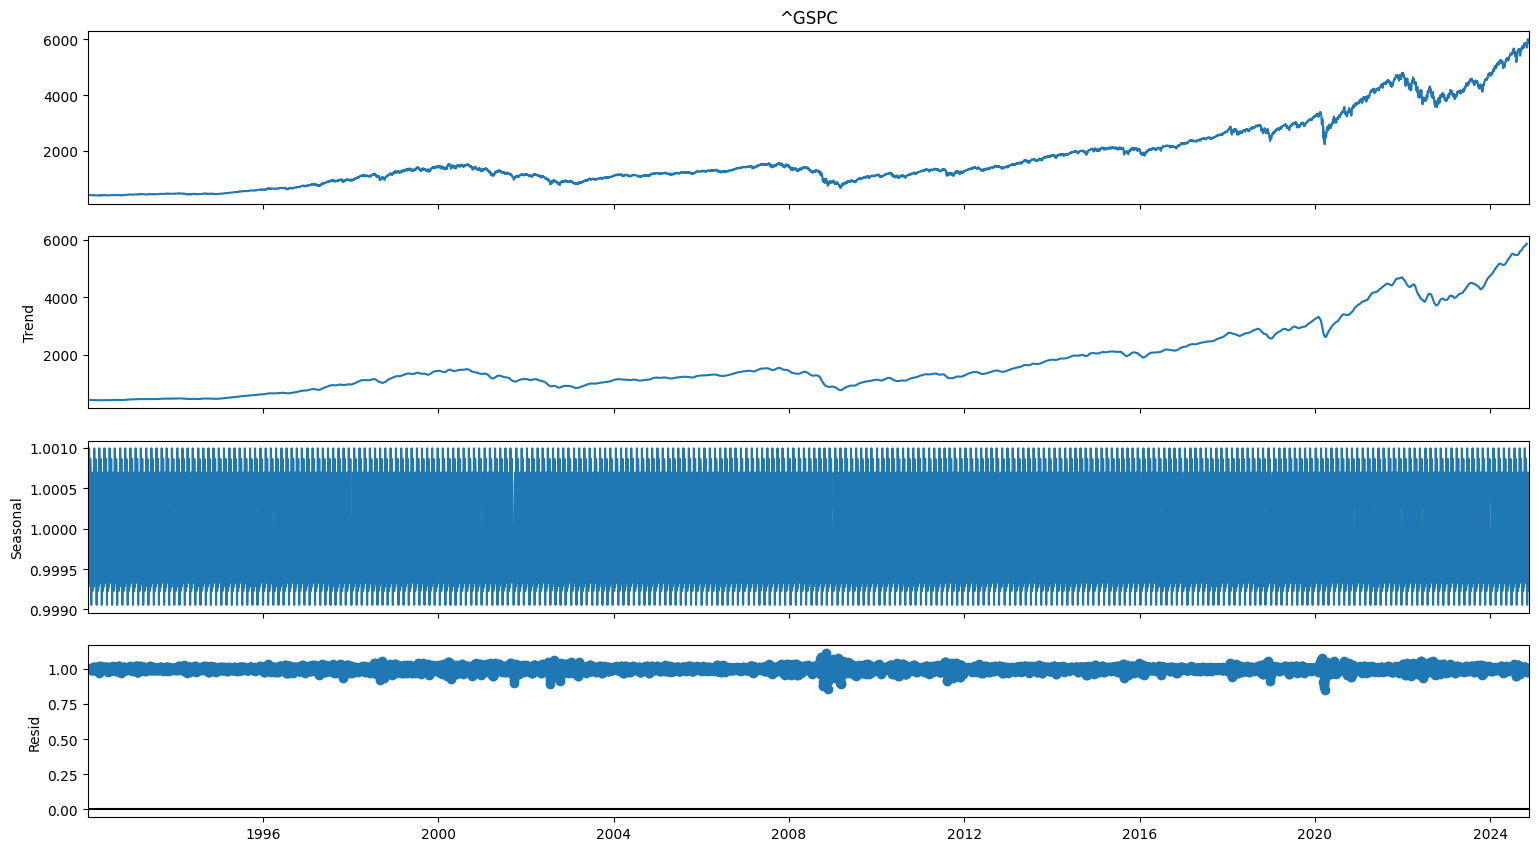

In [63]:
result = seasonal_decompose(sp500_data, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

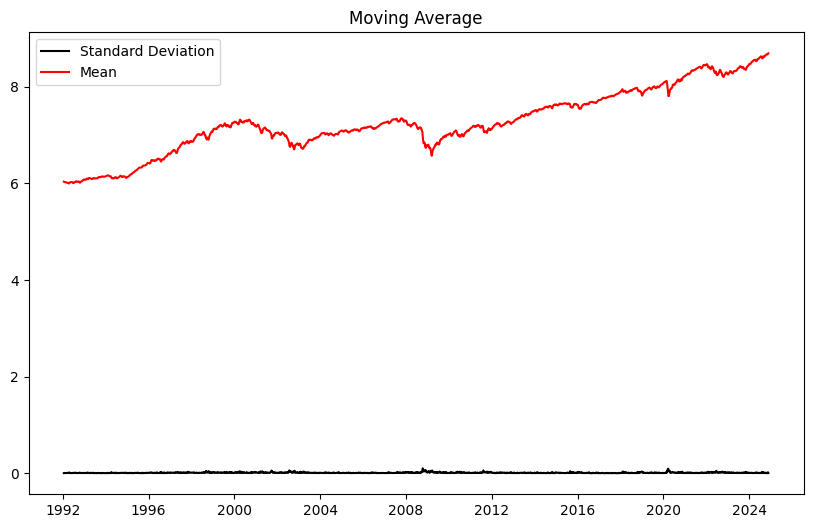

In [33]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(sp500_data)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [34]:
sp500_data.index = sp500_data.index.tz_localize(None)
dowjones_data.index = dowjones_data.index.tz_localize(None)


combined_data = pd.DataFrame({
    'S&P 500': sp500_data,
    'GDP': gdp_data_daily['Real GDP'],
    'Unemployment Rate': unemployment_data_daily['Value'],
    'CPI': cpi_data_daily['CPI'],
    'Interest Rates': interest_rates_daily['Federal Funds Rate'],
    'Consumer Confidence Index': consumer_confidence_daily['Consumer Confidence Index']
})

combined_data = combined_data.fillna(method='ffill')


In [35]:
train_size = int(len(combined_data) * 0.8)

train_data = combined_data.iloc[:train_size]
test_data = combined_data.iloc[train_size:]

y_train = train_data[['S&P 500']]
X_train = train_data[['GDP', 'Unemployment Rate', 'CPI', 'Interest Rates', 'Consumer Confidence Index']]

y_test = test_data[['S&P 500']]
X_test = test_data[['GDP', 'Unemployment Rate', 'CPI', 'Interest Rates', 'Consumer Confidence Index']]


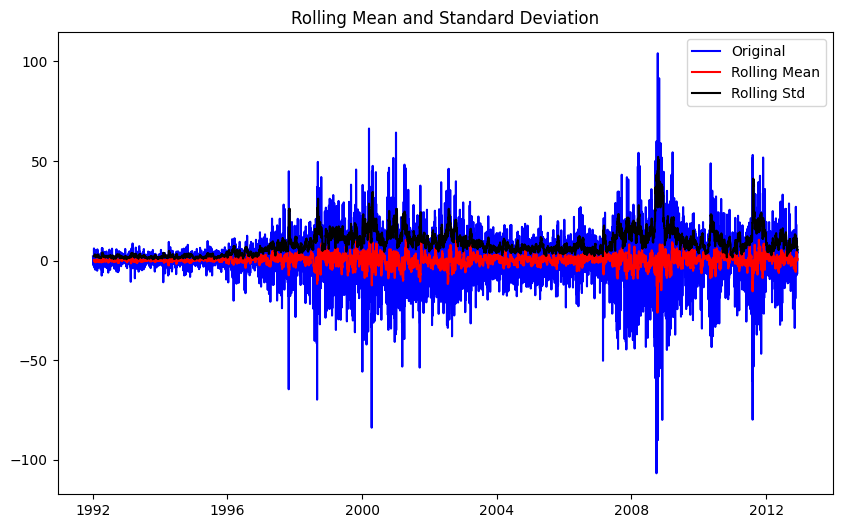

Results of dickey fuller test
Test Statistics               -1.691905e+01
p-value                        9.972463e-30
No. of lags used               2.600000e+01
Number of observations used    7.618000e+03
critical value (1%)           -3.431209e+00
critical value (5%)           -2.861919e+00
critical value (10%)          -2.566972e+00
dtype: float64


In [36]:
# First differencing

y_train['S&P 500_diff'] = y_train['S&P 500'].diff()
# y_train['Dow_diff'] = y_train['Dow'].diff()
y_train = y_train.dropna(subset=['S&P 500_diff'])
# y_train = y_train.dropna(subset=['Dow'])

X_train = X_train.iloc[1:]



y_train['S&P 500_diff'] = y_train['S&P 500_diff'].fillna(method="ffill")

# Recheck stationarity after differencing

test_stationarity(y_train['S&P 500_diff'])
# test_stationarity(y_train['Dow_diff'])



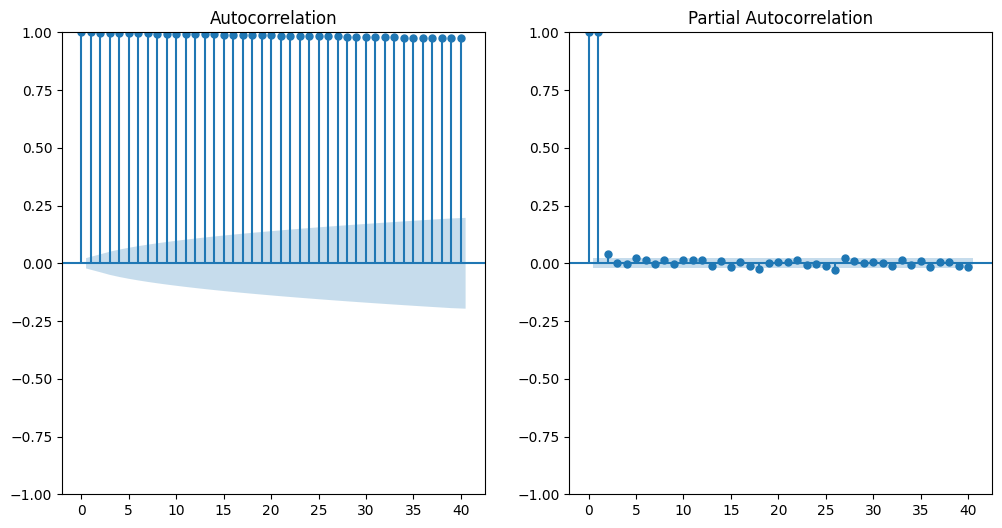

In [37]:
plt.figure(figsize=(12, 6))
plot_acf(y_train['S&P 500'].dropna(), lags=40, ax=plt.subplot(121))  # Autocorrelation
plot_pacf(y_train['S&P 500'].dropna(), lags=40, ax=plt.subplot(122))  # Partial Autocorrelation
plt.show()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=57927.368, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=57897.879, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=57897.795, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=57926.509, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=57899.793, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=57899.793, Time=0.90 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=57892.740, Time=2.45 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=57893.390, Time=2.83 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=57890.813, Time=3.00 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=57901.696, Time=1.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=57874.836, Time=7.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=57887.034, Time=8.49 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=57872.561, Time=6.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=57903.793, Time=0.80 sec
 ARIMA(2,1,1)(0,0,0

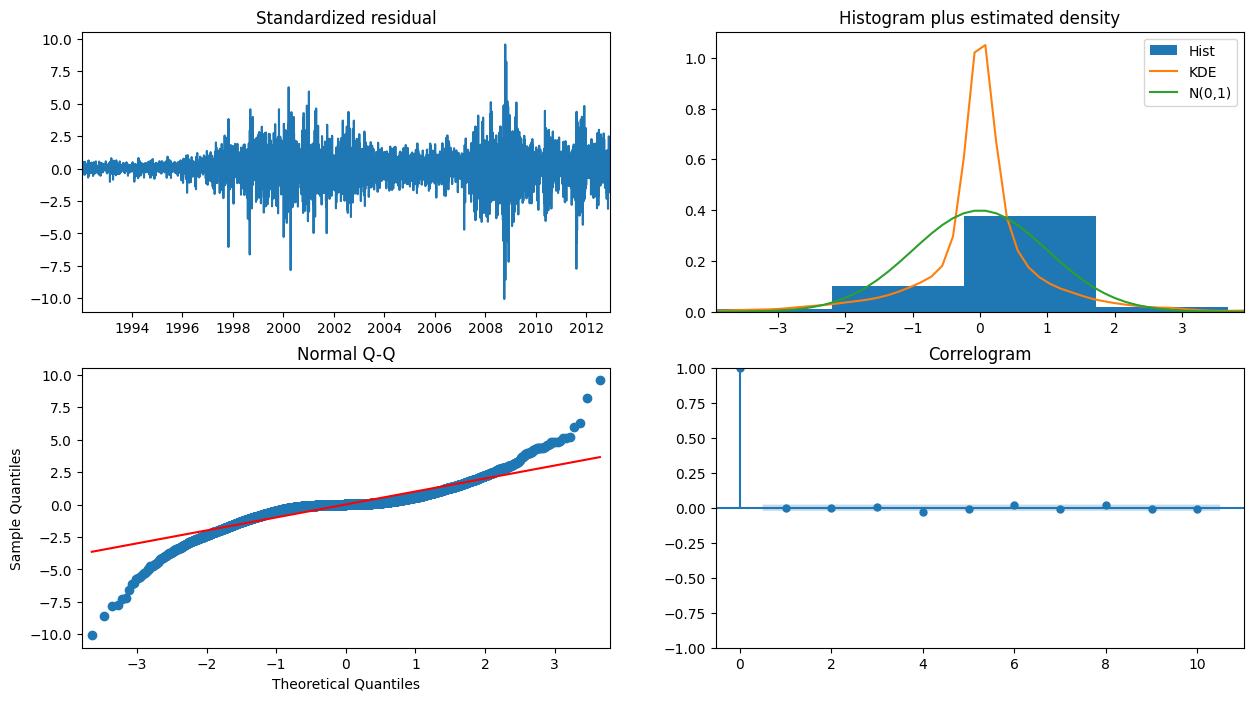

In [39]:
model_autoARIMA = auto_arima(y_train["S&P 500"], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()




In [42]:
model = SARIMAX(y_train["S&P 500"], order=(3,1,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                S&P 500   No. Observations:                 7645
Model:               SARIMAX(3, 1, 2)   Log Likelihood              -28930.014
Date:                Sat, 23 Nov 2024   AIC                          57872.028
Time:                        16:02:30   BIC                          57913.678
Sample:                    01-03-1992   HQIC                         57886.316
                         - 12-07-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8085      0.011    165.734      0.000       1.787       1.830
ar.L2         -0.8413      0.014    -58.157      0.000      -0.870      -0.813
ar.L3         -0.0646      0.007     -9.425      0.0

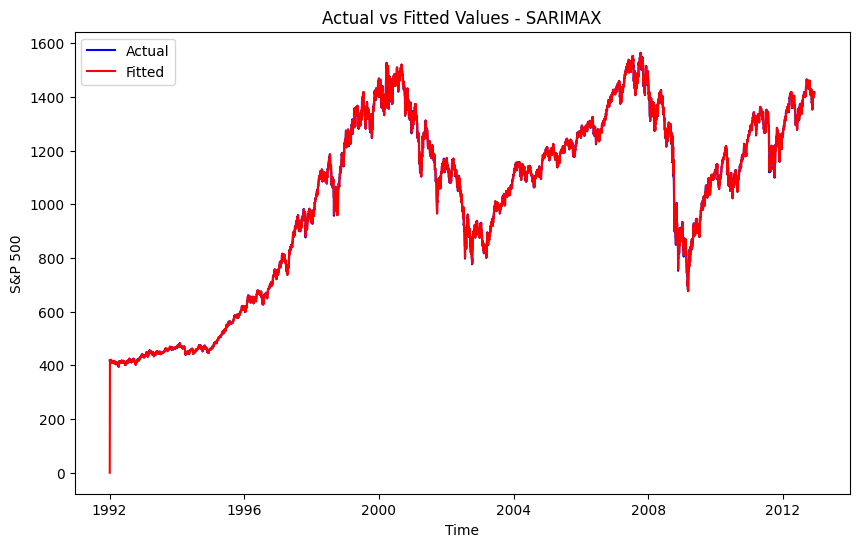

In [52]:
# Generate predictions for the training data
fitted_values = fitted.predict(start=y_train.index[0], end=y_train.index[-1])

# Plot the actual vs fitted values
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train["S&P 500"], label='Actual', color='blue')
plt.plot(y_train.index, fitted_values, label='Fitted', color='red')
plt.title('Actual vs Fitted Values - SARIMAX')
plt.xlabel('Time')
plt.ylabel('S&P 500')
plt.legend()
plt.show()

In [53]:
# Calculate RMSE for S&P 500
rmse_sp500 = np.sqrt(mean_squared_error(y_test['S&P 500'], forecast_sp500))
print(f'S&P 500 RMSE: {rmse_sp500}')

NameError: name 'forecast_sp500' is not defined

In [54]:
# Forecast the next 30 days
future_exog = X_test.iloc[-30:]  # Replace with actual future exogenous variable data
future_forecast = results_sp500.get_forecast(steps=30, exog=future_exog)

# Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(future_forecast.predicted_mean, label='Future Forecast', color='green')
plt.legend()
plt.title('Future Forecast for S&P 500')
plt.show()

NameError: name 'results_sp500' is not defined

## Dash Code

In [ ]:
## Dash Code

app = dash.Dash()

app.layout = html.Div([
    html.H1("Hello Dash!!!"),
    html.Div("Dash - A Data Product")
])

if __name__ == '__main__':
    app.run_server(port=4050)